In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import sys
import numpy as np
from scipy.signal import butter, iirnotch, filtfilt, lfilter
sys.path.append('../analysis/00-functions-tools/python-utils-tools')

In [247]:
from utils_general import load_session, detect_bad_channel, upsample_speed

In [248]:
speed, lfp, int2volt = load_session()
speed = upsample_speed(speed, lfp)
badid = detect_bad_channel(lfp)

def load_minute(epoch, minute):
    start = (epoch * 30 + 5 + minute) * 60 * 2500
    end = start + 60 * 2500
    y = speed[start:end]
    X = np.array(lfp[start:end]) * int2volt
    neighbor = badid + 1 if badid % 2 == 0 else badid - 1 
    X[:, badid] = X[:, neighbor]
    return X, y

Loading  /Users/lukearend/phd/kfx/data/2022-08-11-01-55-00_M018_SAL_mPFC_HPC_0_0_0mpk_g0_t0.imec1.lf.bin
LFP shape after trimming:  (18021770, 126)
Length in minutes of speed recordings:  120.14699999999999
Length in minutes of LFP recordings:  120.14513333333333
Difference in seconds:  0.11200000000008004
Total mean abs LFP across channels over time 05:00-08:00: 6.2077
Bad channel LFP abs average over time 05:00-08:00: 0.76
Bad channel ID: 71
Nearest neighbor channel to bad channel: 70
Upsampled speed shape (18021770,), LFP shape (18021770, 126)


In [262]:
from tqdm import tqdm

# compute channel means
mean = []
for epoch in range(4):
    for minute in tqdm(range(20)):
        X, y = load_minute(epoch, minute)
        mean.append(X.mean(axis=0))
mean = np.array(mean)
mean = mean.mean(axis=0)

def rereference(X):
    X = X - mean
    X = X - np.median(X, axis=1, keepdims=True)
    X = X[:, 0::2] + X[:, 1::2]
    return X

def filter(X):
    b, a = butter(N=5, Wn=[lowfreq, highfreq], btype='band')
    X = filtfilt(b, a, X, axis=0)
    b, a = iirnotch(w0=60, Q=notchq, fs=2500)
    X = lfilter(b, a, X, axis=0)
    return X

def decimate(X):
    return X[::2]

100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


In [263]:
notchq = 200                # 60 Hz notch filter Q
lowfreq = 1 / (2500 / 2)    # bandpass low frequency
highfreq = 300 / (2500 / 2) # bandpass high frequency

In [264]:
epoch = np.random.randint(4)
minute = np.random.randint(20)
X, y = load_minute(epoch, minute)
X = rereference(X)
X = filter(X)
X = decimate(X)
y = decimate(y)

In [272]:
from utils_signal_processing import compute_icsd

Compute iCSD ......
(63, 75000)


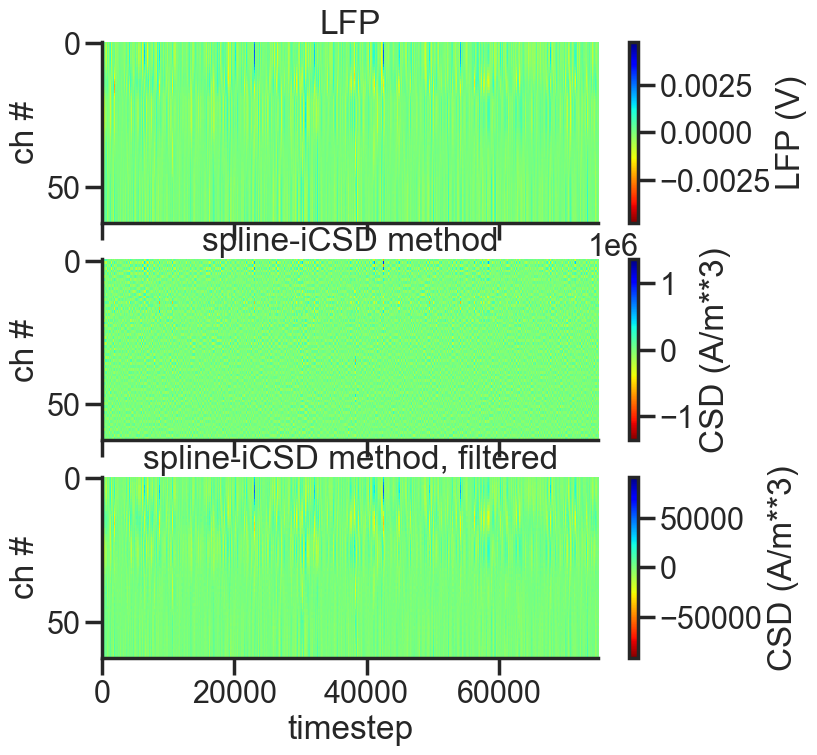

In [281]:
csd, csdfilt = compute_icsd(X, average_y=False, plot_csd=True)

In [280]:
csdfilt.shape

(75000, 31)

In [266]:
import quantities as pq

In [267]:
lfp.shape

(18021770, 126)

In [ ]:
h = 20e-6 * pq.m # electrode spacing 20 microns
V = X.T * pq.V # electrode voltage across time
z = np.linspace(20E-6,20E-6*Lfp.shape[1],Lfp.shape[1]) * pq.m  # [m]
diam = 500E-6 * pq.m                              # [m]
h = 20E-6 * pq.m                                 # [m]
sigma = 0.3 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.3 * pq.S / pq.m 

In [ ]:
spline_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'diam' : diam,
    'sigma' : sigma,
    'sigma_top' : sigma,
    'num_steps' : lfp.shape[1],      # Spatial CSD upsampling to N steps
    'tol' : 1E-12,
    'f_type' : 'gaussian',
    'f_order' : (20, 5),
}